In [1]:
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KernelDensity

In [2]:
real = pd.read_pickle('../data_t-drive/t-drive_cut.pkl')
fake = pd.read_pickle('../machine_learning/generated/citybased_gan_2/g_GRU-32_rand-32_Dense-3_adam_bce_default_d_gin_GRU-16_Dense-1_adam_bce_default_t-drive_64_100_cut.pkl')

In [11]:
fake.head()

longitude   latitude
user time                                                
0    2008-02-02 12:59:25.148941975  116.457764  39.999734
     2008-02-02 13:28:37.714843750  110.551559  38.069439
     2008-02-02 13:59:14.570312500  102.816238  36.263489
     2008-02-02 14:22:01.351562500   83.072327  31.257896
     2008-02-02 14:23:31.351562500   42.581390  18.786726

In [12]:
fake.mean()

longitude    1.599260
latitude     1.361798
dtype: float64

In [3]:
# Load the OSMNX graphs
streets_beijing = ox.load_graphml('beijing_streets_all.graphml', folder='../osmnx_data')

## Simple overview (small map)

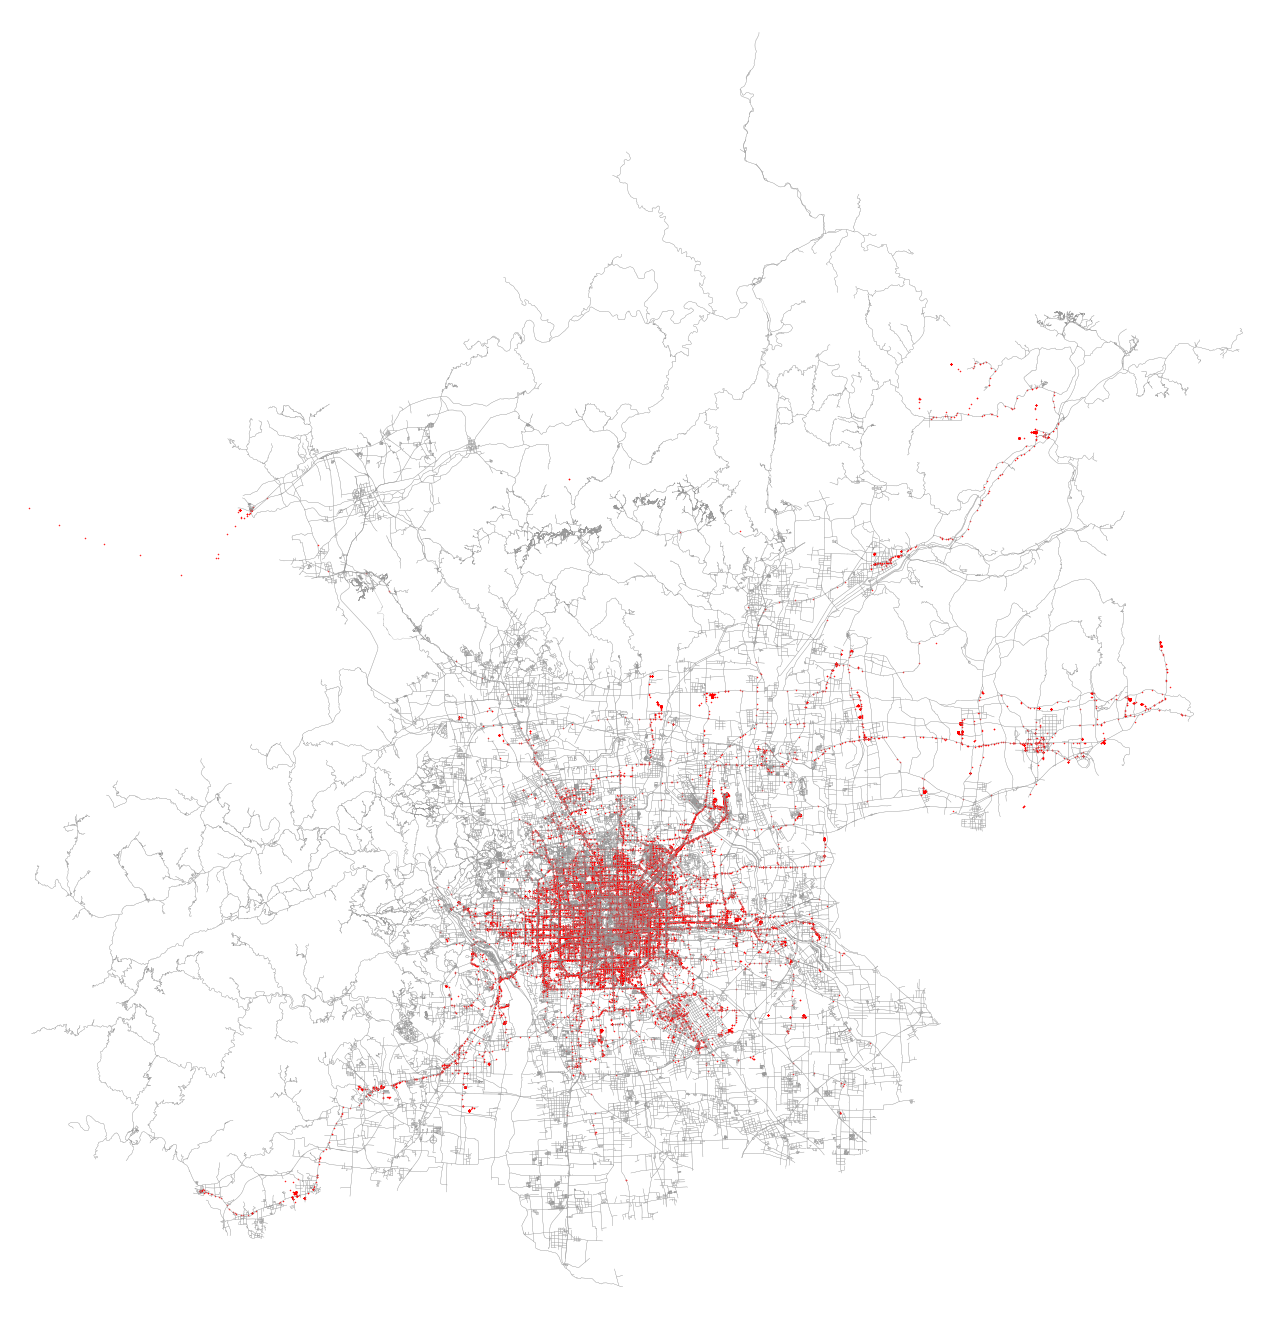

In [6]:
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real['longitude'], real['latitude'], c='#ff0000', s=0.25, alpha=1.0)

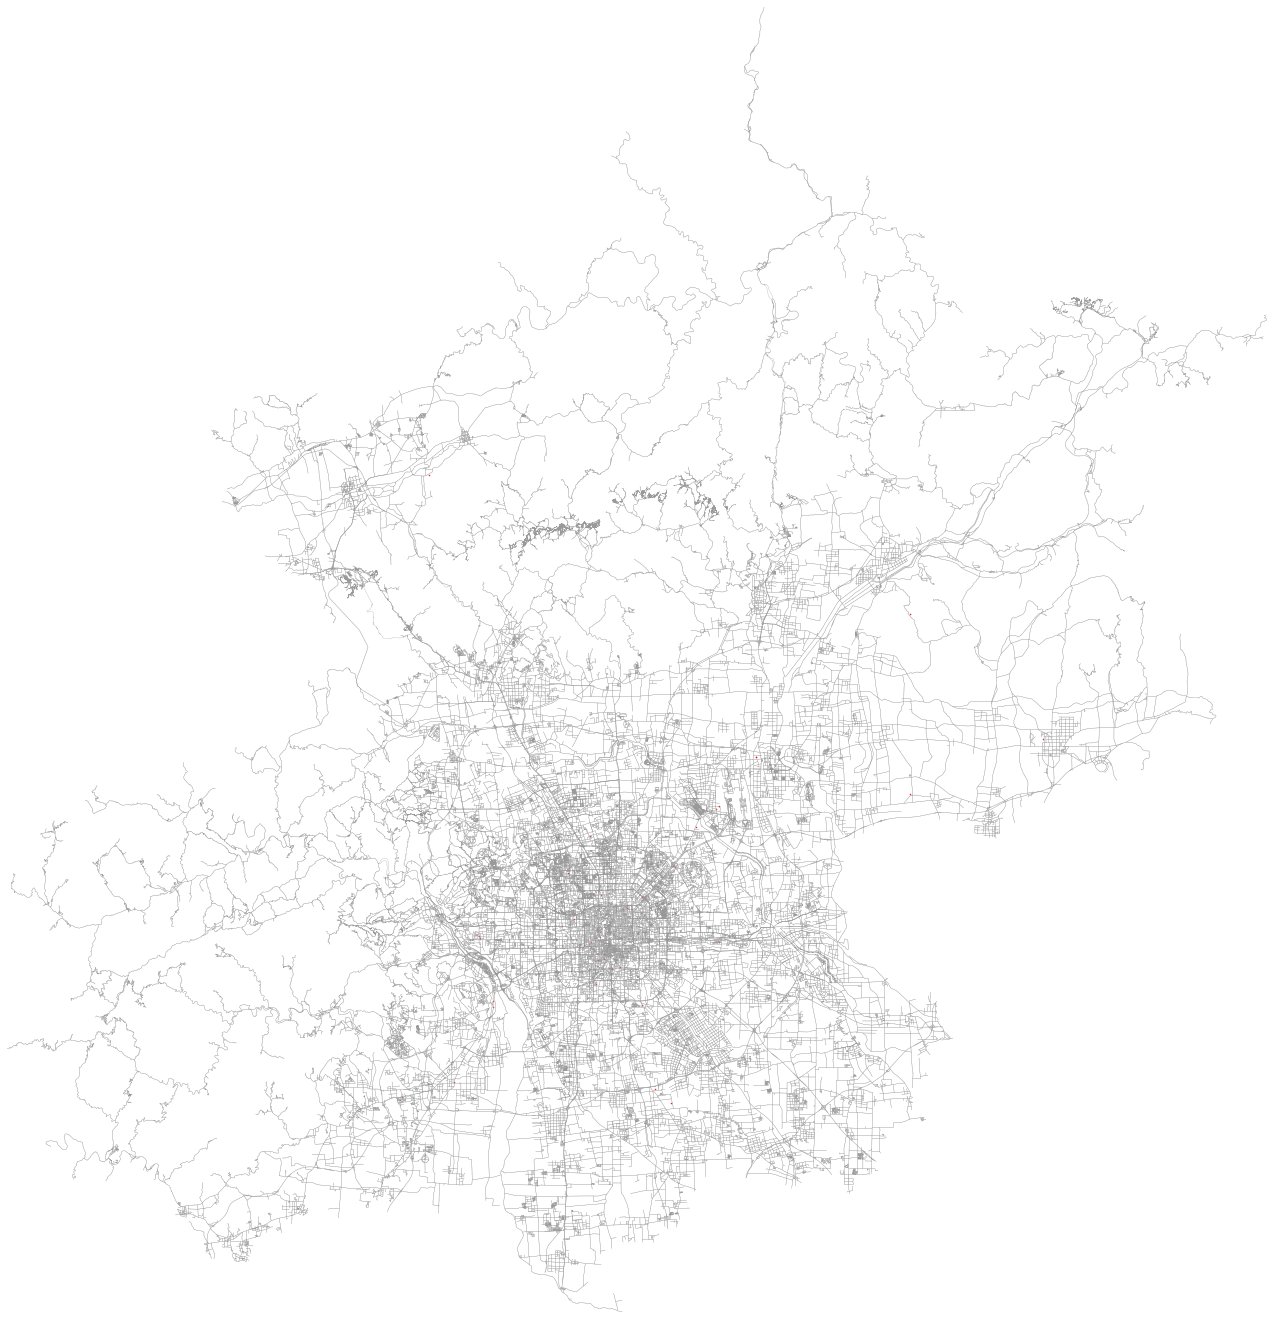

In [4]:
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, margin=0.0,
                        show=False, close=False)
ax.scatter(fake['longitude'], fake['latitude'], c='#ff0000', s=0.25, alpha=1.0)

plt.savefig('../../Images/question_overview_tdrive_gan_2_32_3.png', dpi=100, bbox_inches='tight')

## Histogram of # records in every hour

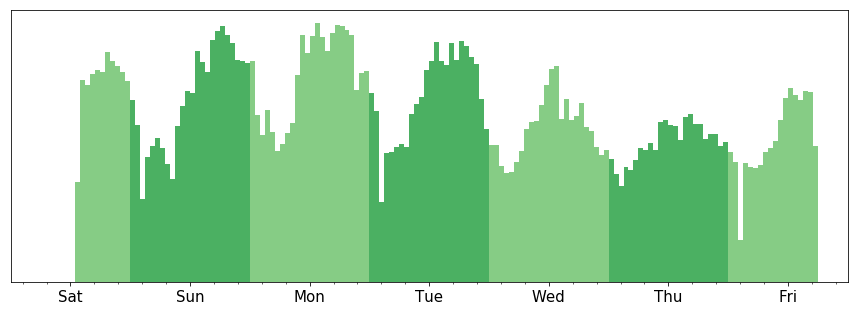

In [3]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(real.index.levels[1], bins=168,
                         range=(pd.Timestamp('2008-02-02 00:00:00'), pd.Timestamp('2008-02-08 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2008-02-02 00:00:00'), pd.Timestamp('2008-02-08 23:59:59'))
plt.xticks([pd.Timestamp('2008-02-02 12:00:00'), pd.Timestamp('2008-02-03 12:00:00'),
           pd.Timestamp('2008-02-04 12:00:00'), pd.Timestamp('2008-02-05 12:00:00'),
           pd.Timestamp('2008-02-06 12:00:00'), pd.Timestamp('2008-02-07 12:00:00'),
           pd.Timestamp('2008-02-08 12:00:00')], 
           ['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)
plt.show()

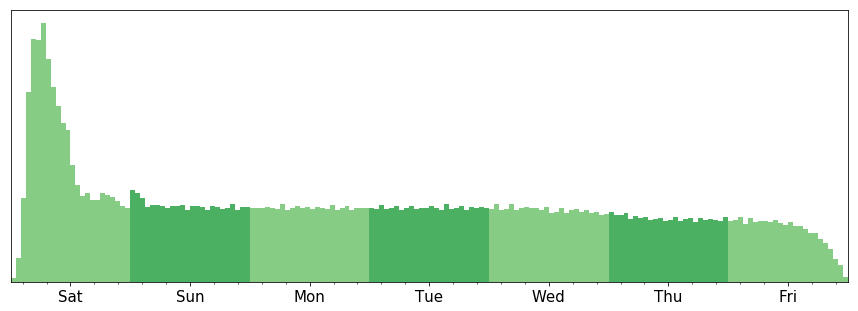

In [5]:
plt.figure(figsize=(15, 5))
_, _, patches = plt.hist(fake.index.levels[1], bins=168,
                         range=(pd.Timestamp('2008-02-02 00:00:00'), pd.Timestamp('2008-02-08 23:59:59')))
cm = plt.cm.Greens
colours = ([0.45]*24 + [0.6]*24)*7
for c, p in zip(colours, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlim(pd.Timestamp('2008-02-02 00:00:00'), pd.Timestamp('2008-02-08 23:59:59'))
plt.xticks([pd.Timestamp('2008-02-02 12:00:00'), pd.Timestamp('2008-02-03 12:00:00'),
           pd.Timestamp('2008-02-04 12:00:00'), pd.Timestamp('2008-02-05 12:00:00'),
           pd.Timestamp('2008-02-06 12:00:00'), pd.Timestamp('2008-02-07 12:00:00'),
           pd.Timestamp('2008-02-08 12:00:00')], 
           ['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
plt.yticks([])
plt.minorticks_on()
plt.tick_params(labelsize=15.0)

plt.savefig('../../Images/question_traffic_tdrive_gan_2_32_3.pdf', dpi=20, bbox_inches='tight')

## Distribution of speeds

In [6]:
def haversine(lat1, lon1, lat2, lon2):
    MILES = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    total_miles = MILES * c
    return total_miles * 1.6

def speed_distribution(ds):
    tmp = ds.reset_index()
    delta_t = tmp.groupby('user')['time'].diff().dt.total_seconds()
    delta_t = delta_t / 3600.0
    prvs_poss = tmp.groupby('user')[['latitude', 'longitude']].shift(1)
    delta_w = haversine(prvs_poss['latitude'], prvs_poss['longitude'], tmp['latitude'], tmp['longitude'])
    speeds = delta_w / delta_t
    
    print(speeds.describe())
    
    plt.figure(figsize=(15, 5))
    plt.hist(speeds, bins=range(0, 150))
    plt.xlim(0, 150)
    plt.yticks([])
    plt.minorticks_on()
    plt.tick_params(labelsize=15.0)

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count    5.705200e+04
mean              inf
std               NaN
min      0.000000e+00
25%      2.644532e-02
50%      2.067302e+00
75%      1.763089e+01
max               inf
dtype: float64


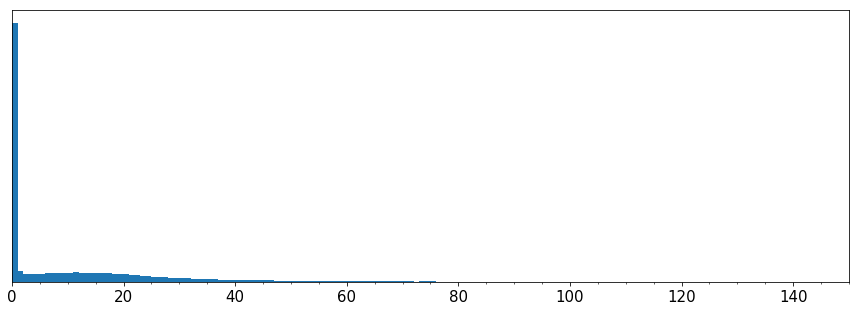

In [4]:
speed_distribution(real)

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in arcsin
  import sys


count     31995.000000
mean        510.158141
std        7979.686792
min           0.034469
25%           2.274921
50%           3.768571
75%           6.394902
max      182763.700274
dtype: float64


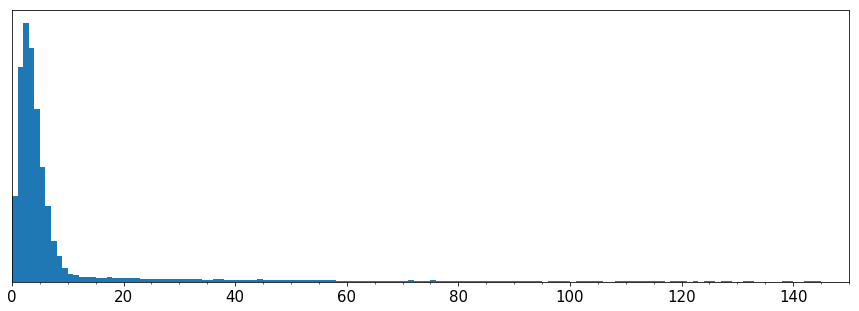

In [7]:
speed_distribution(fake)
plt.savefig('../../Images/question_speeds_tdrive_gan_2_32_3.pdf', dpi=20, bbox_inches='tight')

## One user's data

In [11]:
real.index.levels[0]

Int64Index([  102,   229,   322,   412,   550,   609,   623,   674,   859,
             1023,  1088,  1208,  1218,  1283,  1326,  1606,  1764,  2257,
             2340,  3030,  3269,  3308,  3545,  3861,  4159,  4171,  4243,
             5047,  5140,  5891,  5914,  6585,  6598,  6749,  7159,  7365,
             7443,  8266,  8637,  8744,  8864,  8882,  8930,  9037,  9238,
             9363,  9786,  9988, 10123, 10334],
           dtype='int64', name='user')

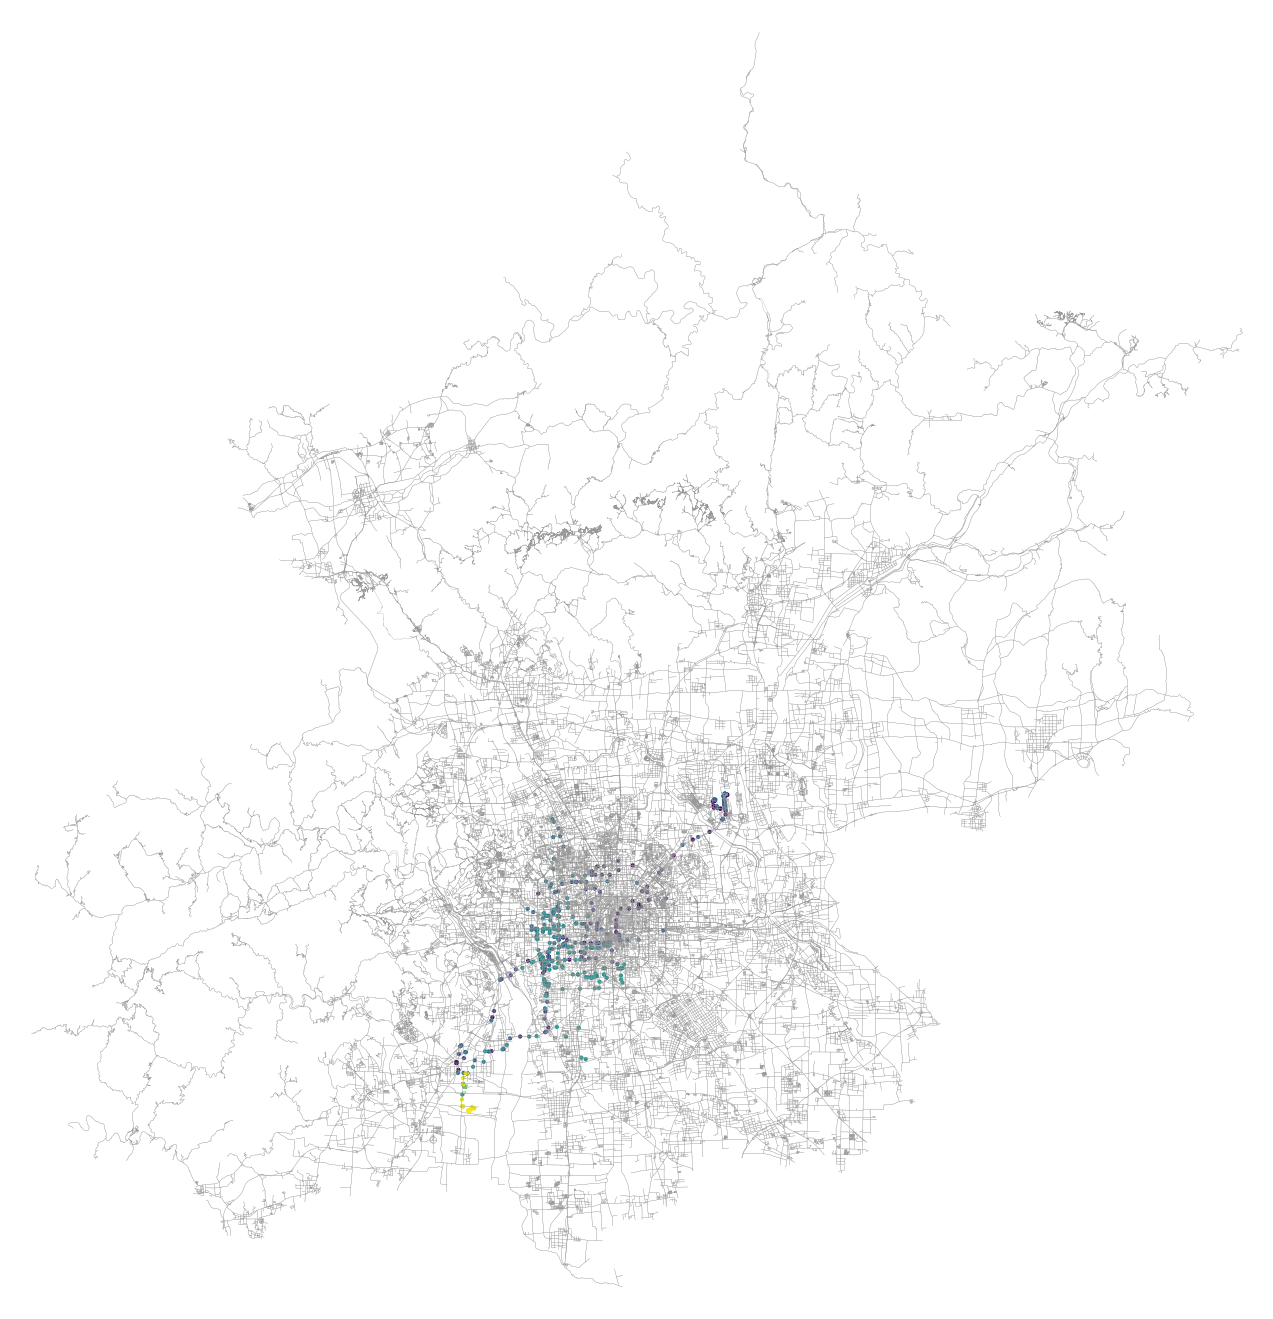

In [13]:
user = 623
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(real.loc[user]['longitude'], real.loc[user]['latitude'], c=real.loc[user].index, s=10.0, alpha=1.0)

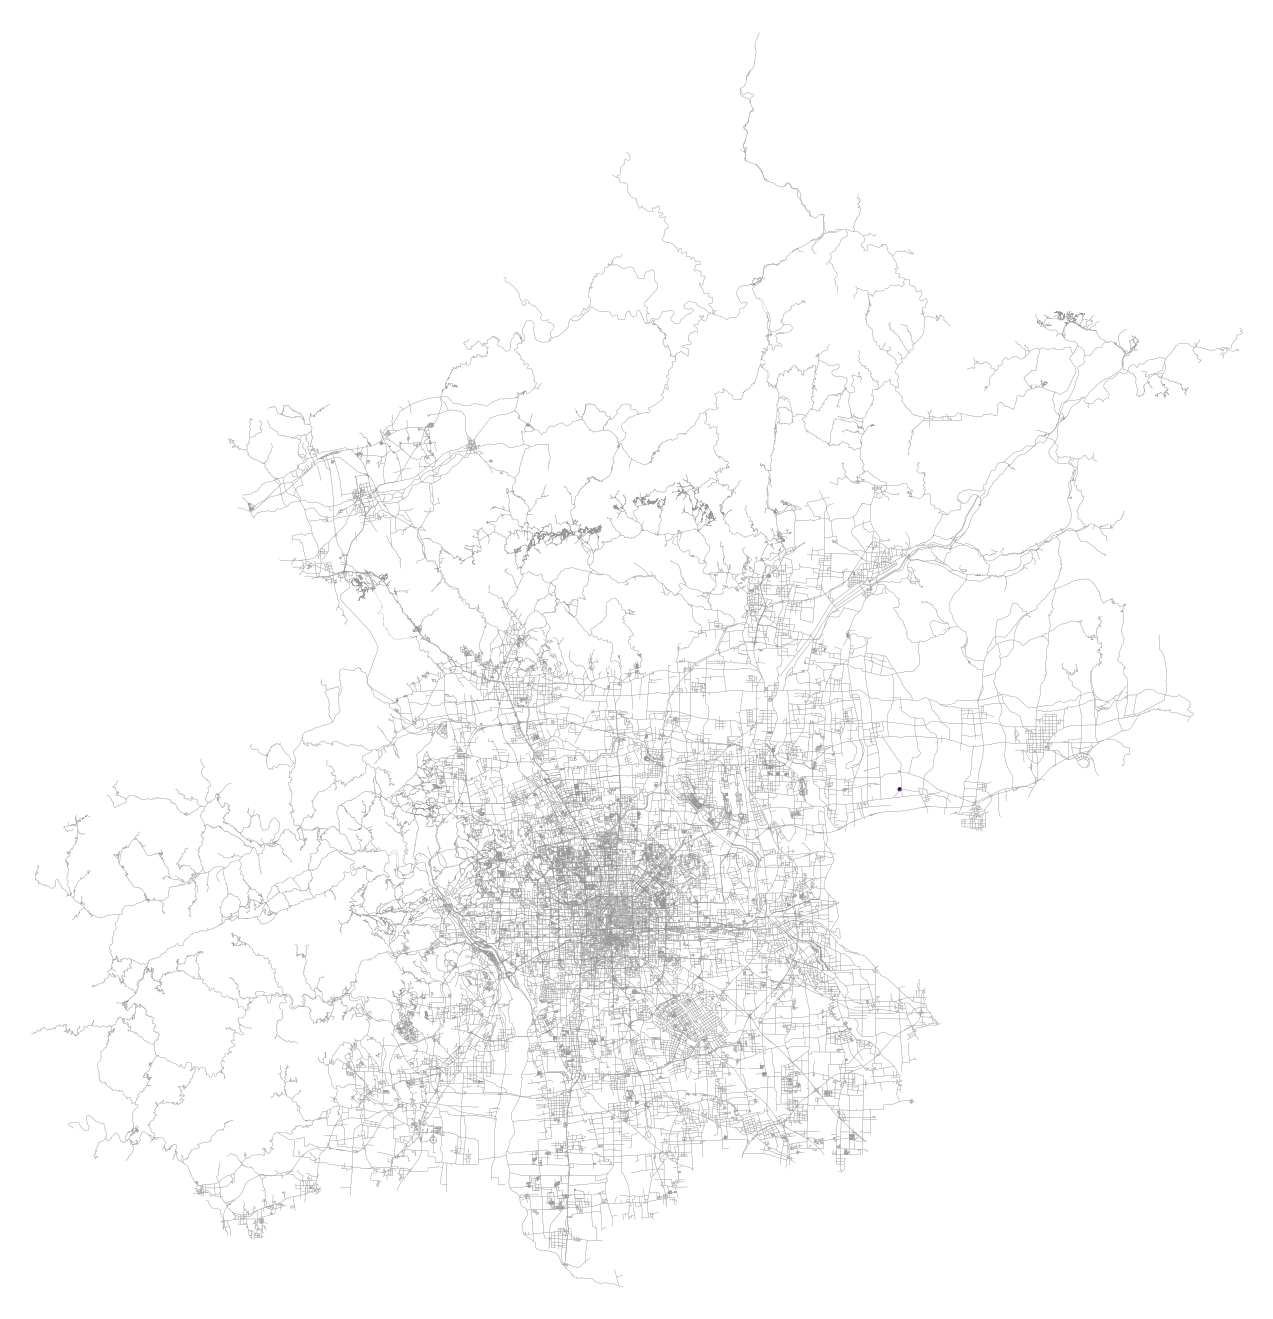

In [15]:
user = 24
fig, ax = ox.plot_graph(streets_beijing, fig_height=24, node_size=0, edge_linewidth=0.25, show=False, close=False)
ax.scatter(fake.loc[user]['longitude'], fake.loc[user]['latitude'], c=fake.loc[user].index, s=10.0, alpha=1.0)